In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [1]:
from __future__ import print_function
import tensorflow as tf
import numpy as np
from scipy.stats import gaussian_kde
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers.core import Dense, Dropout, Activation
import pandas as pd
from matplotlib import pyplot as plt
from keras.optimizers import RMSprop
from keras.utils import np_utils
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats

%matplotlib inline

Using TensorFlow backend.


In [2]:
# Plot the observed values versus predicted using density plot
def density_plot(x, y):
    ''' x = observed, y = predicted '''
    x = x[(~np.isnan(x)) & (~np.isnan(y))]
    y = y[(~np.isnan(x)) & (~np.isnan(y))]

    # Calculate the point density
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]

    # formatting
#     plt.figure(figsize=[8, 6])
    plt.scatter(x, y, c=z, s=3, edgecolor='', cmap='viridis_r')
#     plt.xlim(0, 1)
#     plt.ylim(0, 1)
    plt.xlabel('Observed brightness')
    plt.ylabel('Predicted brightness')
    plt.title(chunk)
    plt.tick_params(axis="both", which="both", bottom="off", top="off",
                    labelbottom="on", left="off", right="off", labelleft="on")
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.gca().spines["bottom"].set_color('gray')
    plt.gca().spines["left"].set_color('gray')
    plt.gca().xaxis.grid(True)
    plt.gca().yaxis.grid(True)

In [3]:
def read_data(chunk):
    input_file = '/home/katya/local/HIS3InterspeciesEpistasis/Analysis/Katya/NN/' + chunk + '.txt'
    data = pd.read_table(input_file)
    data.mut_list = data.mut_list.fillna('')
    unique_mutations = set(':'.join(data.mut_list).split(':'))
    unique_mutations = sorted(list(unique_mutations))
    if '' in unique_mutations:
        unique_mutations.remove('')

    data = data.reindex(np.random.permutation(data.index))
    nn_genotypes_values = np.zeros((len(data), len(unique_mutations)))
    nn_brightness_values = data.fitness.values
    
    for i in range(len(unique_mutations)):
        nn_genotypes_values[:, i] = data.mut_list.str.contains(unique_mutations[i]).astype(np.float32)

    nn_brightness_values = (nn_brightness_values - min(nn_brightness_values)) / max(
        nn_brightness_values - min(nn_brightness_values))
    
    return nn_genotypes_values, nn_brightness_values

In [4]:
def dot_plot(char, label):
    plt.figure(figsize=[10,7])
    plt.tick_params(axis="both", which="both", bottom="off", top="off",
                        labelbottom="on", left="off", right="off", labelleft="on")
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.gca().spines["bottom"].set_color('gray')
    plt.gca().spines["left"].set_color('gray')
    plt.gca().xaxis.grid(True)
    plt.gca().yaxis.grid(True)
    plt.plot([x for x in range(1, 13)], char, 'ok')
    plt.xlabel('Segment', fontsize=13)
    plt.ylabel(label, fontsize=13)
    plt.xticks([x for x in range(1, 13)])

In [5]:
def fitness_potential_plotting(weights_set):
    plt.figure(figsize=(4*5+3,3*5))
    plt.suptitle('Weights, neuron #%d' %weights_set, size=30, x=0.8, y=1.6)
    count=1
    for chunk in chunks:
        plt.subplot(3,4,count)
        plt.subplots_adjust(top = 1.5,right=1.5)
        plt.title(chunk, fontsize=20)

        plt.plot(fitness_potential[chunk][:,weights_set][:10000], true[chunk][:10000], 'ok', alpha = 0.01)
        plt.plot(fitness_potential[chunk][:,weights_set][:10000], predicted[chunk][:10000], '.', c='#36D1C4', alpha = 0.03)
        
        plt.grid(True, ls='--', lw=0.5, dash_capstyle = 'round', c='gray')
        plt.xlabel('Fitness potential', fontsize=15)
        plt.ylabel('Observed values', fontsize=15)
        count+=1

## Testing

In [26]:
chunk = 'S1'

data, labels = read_data(chunk)

model = Sequential()
model.add(Dense(3, activation='sigmoid', input_dim=data.shape[1], kernel_initializer='random_uniform'))
model.add(Dense(10, activation='sigmoid', kernel_initializer='random_uniform'))
model.add(Dense(1, activation='sigmoid', kernel_initializer='random_uniform'))

model.compile(optimizer='adagrad',
              loss='mean_squared_error',
              verbose=0)

hist[chunk] = model.fit(data, labels, epochs=100, batch_size=500, shuffle=True, verbose=0)
proba = model.predict_proba(data, batch_size=500, verbose=0)

weights[chunk] = model.layers[0].get_weights()[0]
biases[chunk] = model.layers[0].get_weights()[1]

true[chunk] = labels
predicted[chunk] = proba.flatten()
fitness_potential[chunk] = data.dot(weights[chunk])

In [32]:
fitness_potential[chunk][:,0].shape

(60848,)

In [28]:
weights[chunk].shape

(215, 3)

# Batch

In [6]:
chunks = [('S'+str(x)) for x in range(1,13)]
true = {}
predicted = {}
fitness_potential = {}
hist = {}
weights = {}
biases = {}

In [ ]:
for chunk in chunks:
    print (chunk)
    data, labels = read_data(chunk)
    
    model = Sequential()
    model.add(Dense(100, activation='sigmoid', input_dim=data.shape[1], kernel_initializer='random_uniform'))
    model.add(Dense(10, activation='sigmoid', kernel_initializer='random_uniform'))
    model.add(Dense(1, activation='sigmoid', kernel_initializer='random_uniform'))

    model.compile(optimizer='adagrad',
                  loss='mean_squared_error',
                  verbose=0)
    
    hist[chunk] = model.fit(data, labels, epochs=500, batch_size=500, shuffle=True, verbose=0)
    proba = model.predict_proba(data, batch_size=500, verbose=0)
    
    weights[chunk] = model.layers[0].get_weights()[0]
    biases[chunk] = model.layers[0].get_weights()[1]
    
    true[chunk] = labels
    predicted[chunk] = proba.flatten()
    fitness_potential[chunk] = data.dot(weights[chunk])

S1


/home/katya/anaconda3/envs/python2/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:2096: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


S2
S3
S4
S5
S6
S7
S8
S9
S10


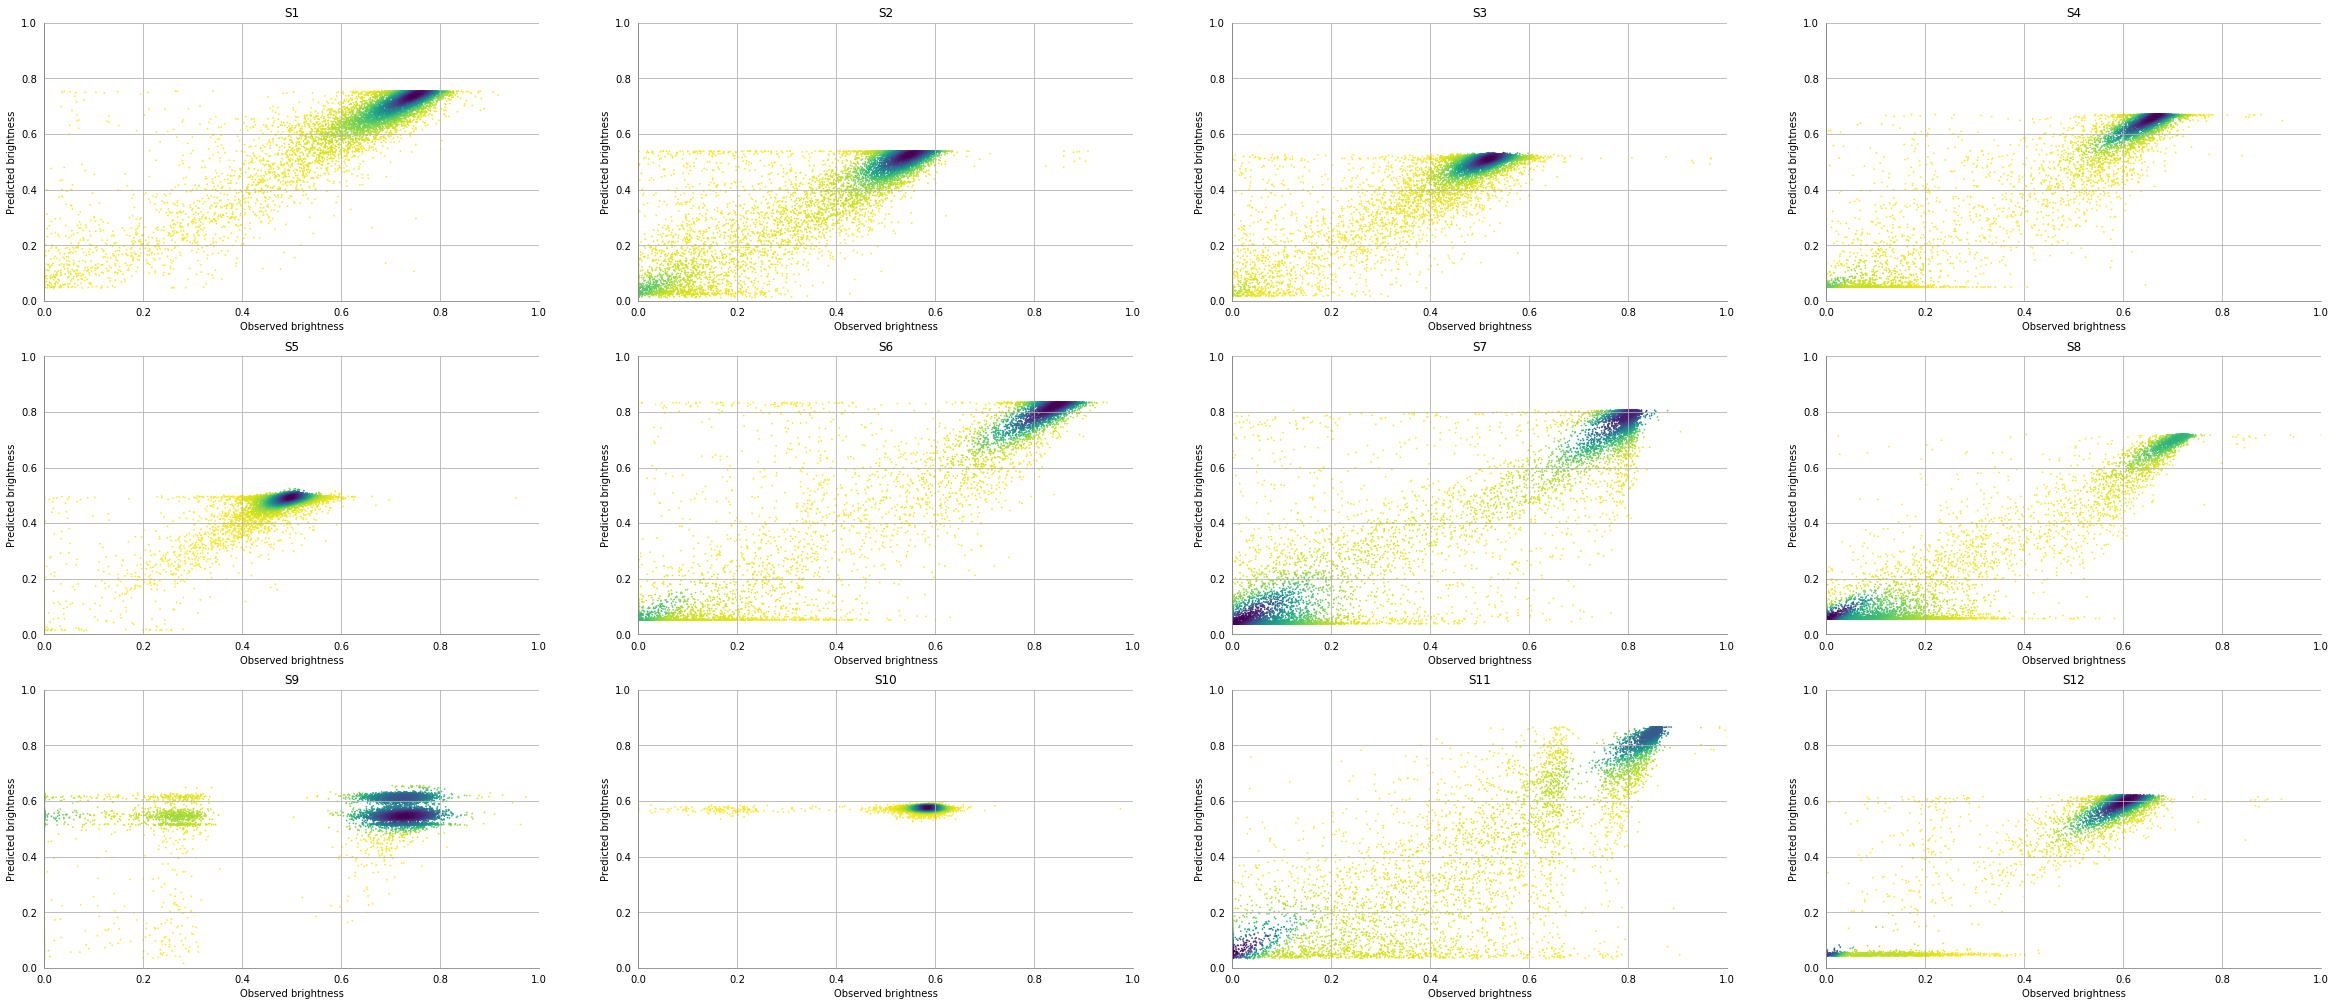

In [11]:
plt.figure(figsize=(4*5+3,3*5))
count=1
for chunk in chunks:
    plt.subplot(3,4,count)
    plt.subplots_adjust(top = 1,right=1.5)
    plt.title(chunk)
    plt.ylim(0,1)
    plt.xlim(0,1)
    density_plot(true[chunk][:10000], predicted[chunk][:10000])
    count+=1

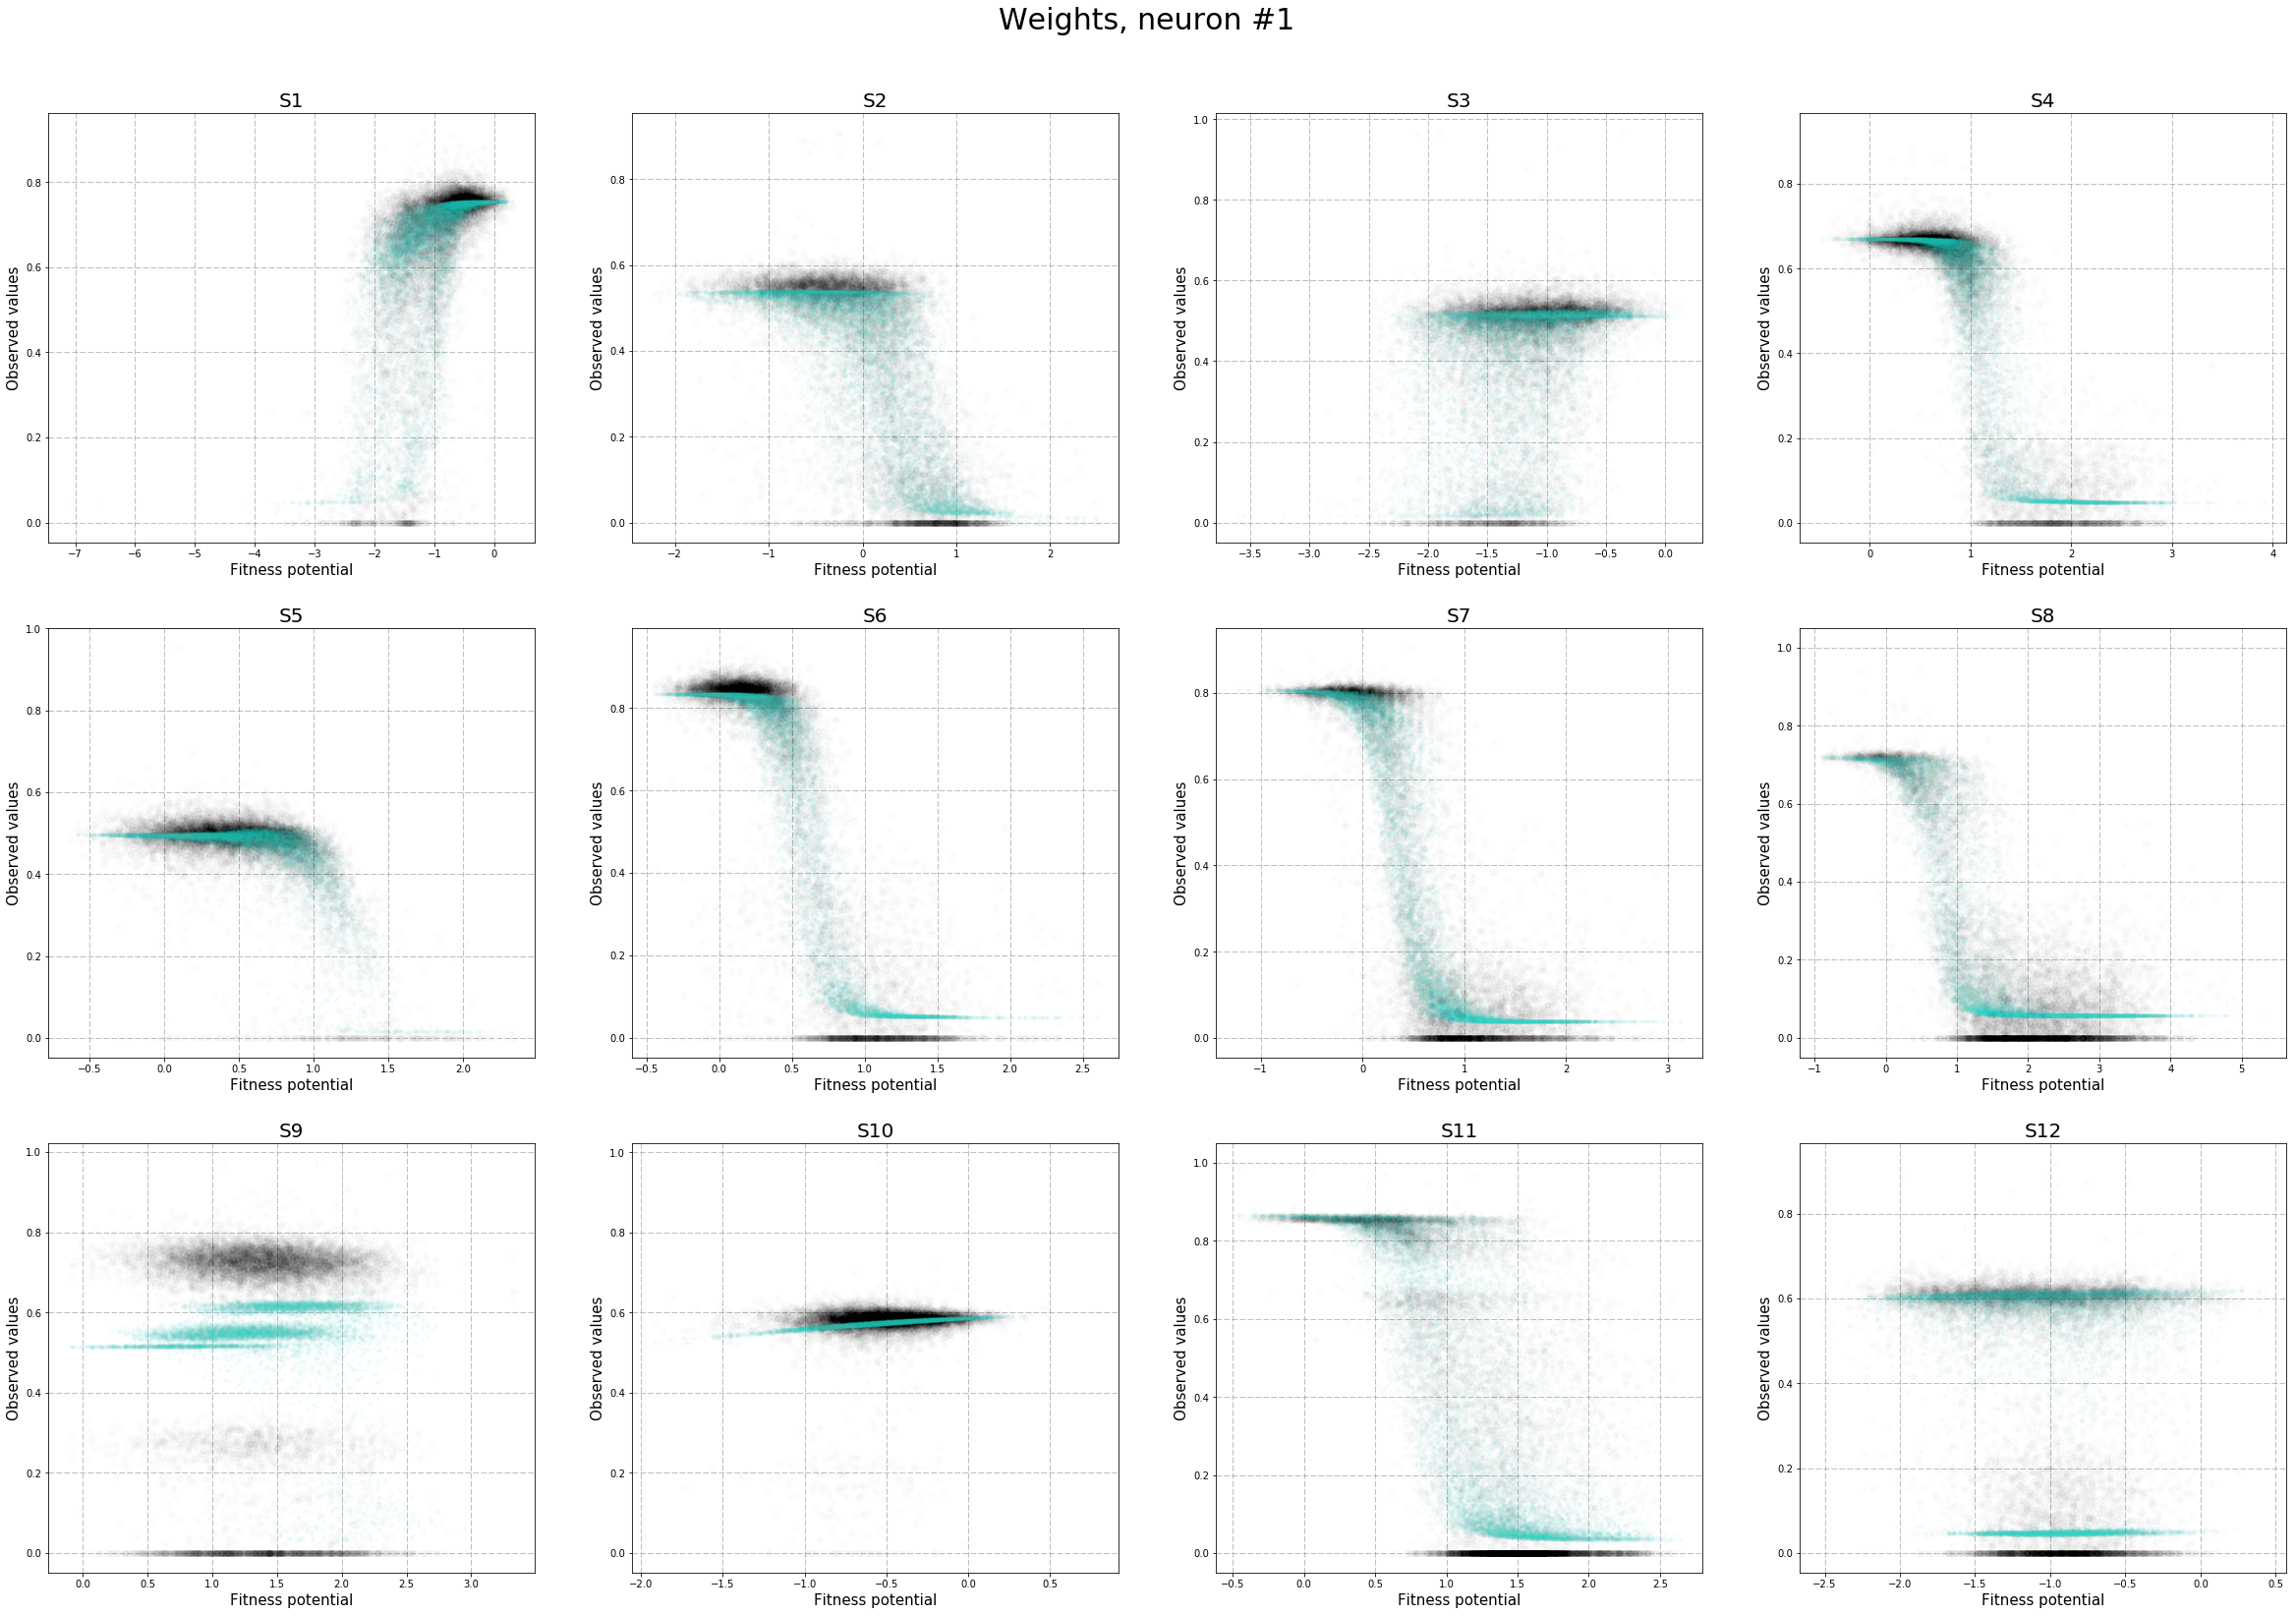

In [13]:
fitness_potential_plotting(1)

In [ ]:
plt.figure(figsize=(4*5+3,3*5))
count=1
for chunk in chunks:
    plt.subplot(3,4,count)
    plt.subplots_adjust(top = 1,right=1.5)
    plt.title(chunk)
    plt.plot([x for x in range(500)], hist[chunk].history['loss'])
    plt.grid(True, ls='--', lw=0.5, dash_capstyle = 'round', c='gray')
    plt.xlabel('Iteration #')
    plt.ylabel('Loss function')
    count+=1

## Correlations

In [20]:
mse = []

for chunk in chunks:
    mse.append(hist[chunk].history['loss'][-1])

In [21]:
r_values = []

for chunk in chunks:
    y = true[chunk]
    y_pred = predicted[chunk]
    slope, intercept, r_value, p_value, std_err = stats.linregress(y,y_pred)
    r_values.append(r_value)

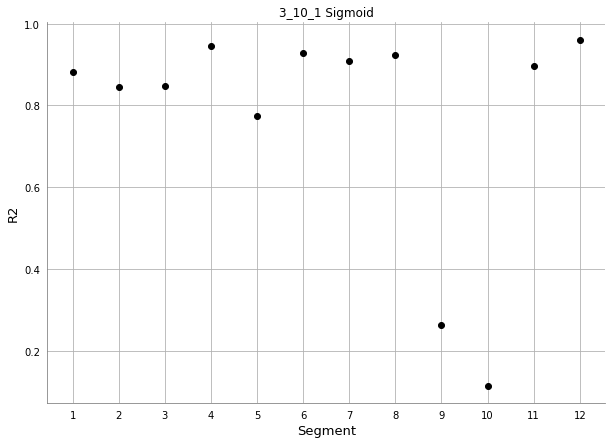

In [98]:
dot_plot(r_values, 'R2')
plt.title('3_10_1 Sigmoid');

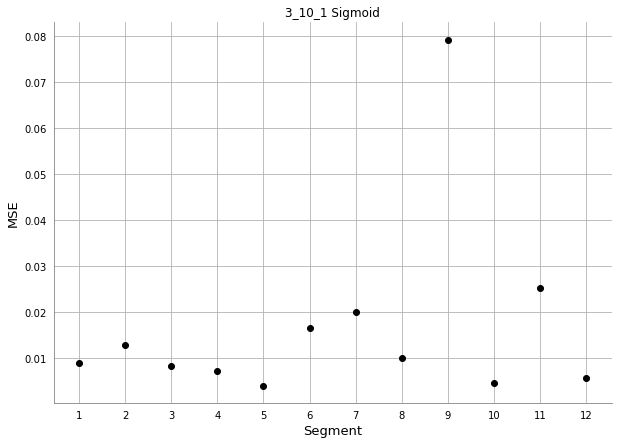

In [99]:
dot_plot(mse, 'MSE')
plt.title('3_10_1 Sigmoid');

## Plotting different weights

In [16]:
r2 = {}

for chunk in chunks:
    r2[chunk] = []
    for w1 in range(100):
        for w2 in range(100):
            if w1!=w2:
                slope, intercept, r_value, p_value, std_err = stats.linregress(weights[chunk][:,w1],weights[chunk][:,w2])
                r2[chunk].append(r_value)
                
data = pd.DataFrame.from_dict(r2)

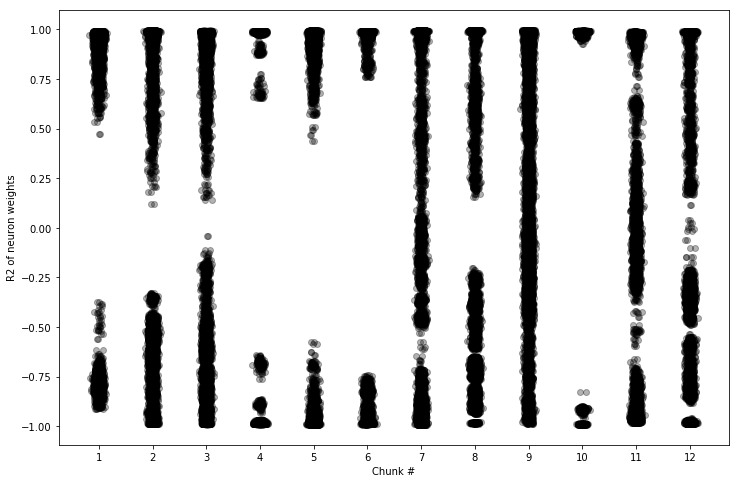

In [17]:
plt.figure(figsize=[12,8])
for i in range(1,13):
    y = data['S'+str(i)]
    x = np.random.normal(i, 0.04, size=len(y))
    plt.plot(x, y, 'k.', alpha=0.3, ms=12)
    plt.xticks([x for x in range(1,13)])
    plt.xlabel('Chunk #', fontsize=15)
    plt.ylabel('R2 of neuron weights', fontsize=15)
    plt.grid(True, ls='--', lw=0.5, dash_capstyle = 'round', c='gray')